0. Úprava dat,snížení šumu, 
1. Trénovací data (realné nebo vygenerované)
    - zahrnout aberace, apodizace a šumové hodnoty
    - zkombinovat reálné a vygenerované? 
    - augmentovat obrázky pro zvýšení trénovacích obrázků (rotace, změna velikosti apod.)
    - normalizace dat
2. Vytvořit model (konvoluční síť x UNET)
    - UNet je spíše na segmentaci pro biomedícnské data 
    
3. Natrénovat model
    - kolik epoch apod
    - pozor na přetrénování
4. Validace modelu 
    - na realných datech
    - vygenerovaných datech


In [31]:
#run only if your pc dont have these packeges
#if is there issue with install, put code to the python prompt (anaconda prompt) or console without _!_

# !pip install opencv-contrib-python
# !pip install deeptrack
# !pip install scipy
#!pip install visualkeras #only for model visualization

ERROR: Invalid requirement: '#only'


In [2]:
#Initialization (importing packeges )

import numpy as np
import matplotlib.pyplot as plt
import math 
import deeptrack as dt
import scipy.io
import cv2 as cv
import keras
import keras.backend as K
import keras.optimizers as optimizers

from tensorflow.keras import layers
from numpy.random import randint, uniform, normal, choice
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

IMAGE_SIZE = 56

## Training data

In [72]:
#Define particle for training

particle = dt.MieSphere(
    position = lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.concatenate((np.round(np.random.rand(1)*uniform(-1,1)* int(IMAGE_SIZE/4)),np.round(np.random.rand(1)*uniform(-1,1)* int(IMAGE_SIZE/4)))) ,
    #position = (IMAGE_SIZE / 2, IMAGE_SIZE / 2),
    z = lambda: np.random.rand()*25, #pohyb částice v z je od 0 - 25 px (max z=530e3)
    #radius =0.5e-6,
    radius = lambda: (1e-6 + np.random.rand()*9e-7)/2,  #
    refractive_index = 1.455,
    position_unit="pixel",
)

In [4]:
# Define optic system 

test_optics = dt.Brightfield(
        NA=0.23,
        resolution=4.5e-6,
        magnification=20,
        wavelength=532e-9,
        padding=(int(IMAGE_SIZE/2),int(IMAGE_SIZE/2),int(IMAGE_SIZE/2),int(IMAGE_SIZE/2)),
        output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)



In [4]:
#Aberrations
aberration = dt.SphericalAberration(coefficient=lambda: (2 * np.random.rand() - 1) * 4)
aberration = dt.GaussianApodization(sigma=0.5)
aberration=dt.Piston(coefficient=-1)
aberration=dt.ObliqueAstigmatism(coefficient=0)
aberration=dt.Astigmatism(coefficient=-0.5)
aberration=dt.ObliqueTrefoil(coefficient=1)

In [101]:
# add noise and normalization to training data
make_some_noise=dt.Gaussian(mu= 1, sigma= lambda:np.random.rand(1)*0.08 )
make_it_equal=dt.NormalizeMinMax(min=0,max=1)

#imaged_particle = test_optics(particle,aberration = aberration)
imaged_particle = test_optics(particle)
output_image_train = imaged_particle + make_some_noise+make_it_equal


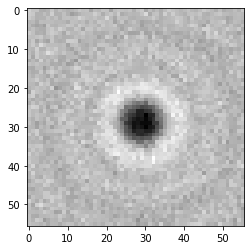

In [114]:
#Showing images of particle

output_image = output_image_train.update().resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()


## Testing data

In [115]:
# testing data with specific positon 
test_pos=[4,10]
particle_test = dt.MieSphere(
    position = lambda:(IMAGE_SIZE / 2, IMAGE_SIZE / 2) + choice(range(test_pos[0],test_pos[1])),
    #position = (IMAGE_SIZE / 2, IMAGE_SIZE / 2),
    z = lambda: np.random.rand()*25, #pohyb částice v z je od 0 - 25 px (max z=530e3)
    #radius =0.5e-6,
    radius = lambda: (5e-7 + np.random.rand()*2.5e-7)/2,  #
    refractive_index = 1.455,
    position_unit="pixel",
)

In [116]:
make_some_noise=dt.Gaussian(mu= lambda:np.random.rand(1)*0.002, sigma= lambda: np.random.rand(1)*0.004)
make_it_equal=dt.NormalizeMinMax(min=0,max=1)

particle_test_image = test_optics(particle_test)
particle_test_image = particle_test_image + make_some_noise+make_it_equal

## Design of neural network and generator

In [117]:
#Function for obtaining position of particle

def get_position_of_particle(image):
    
    # Inputs: image of particle (data type: dt image)
    #
    # Outputs: labels: [0] position in x 
    #                  [1] position in y
    #                  [2] position in z
    # All the properties is scaled by IMAGE_SIZE
    
    labels=np.asarray(image.get_property("position")) / IMAGE_SIZE
    z=image.get_property("z")/ IMAGE_SIZE
    labels=np.append(labels,np.array(z))
    
    return labels 

In [118]:
#generator of images for neural network

generator = dt.generators.ContinuousGenerator(
    output_image_train, #where function get images
    get_position_of_particle, #where function get propertis of images (x,y,z)
    batch_size=32, #how much images function generete 
    min_data_size=1024,
    max_data_size=4168
)

In [119]:
# Design of neural network

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), 
    conv_layers_dimensions=(8,16,32,64),   
    dense_layers_dimensions=(64,64),  
    dense_block=dt.layers.DenseBlock(activation="relu"),
    pooling_block=dt.layers.PoolingBlock(padding="valid"),
    steps_per_pooling=2,
    number_of_outputs = 3, 
    loss="mae" ,
       
)

#model.summary()

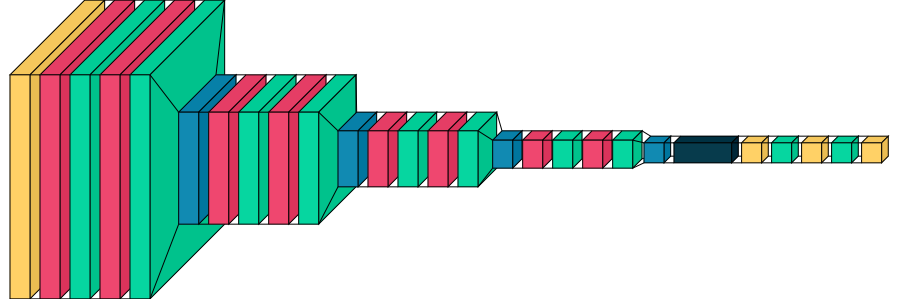

In [120]:
#visualisation of model
import visualkeras
from collections import defaultdict
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'green'
color_map[ZeroPadding2D]['fill'] = 'green'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'green'
color_map[Dense]['fill'] = 'green'

visualkeras.layered_view(model)



 se sigmoidou to chce velmi velkou hromadu epoch a po 25 se mi to sekne.. zkusit jinou aktivaní funkci než sigmoidu
 
 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    dense_layers_dimensions=(64,64),    
    number_of_outputs = 4, 
    loss="mse"
 
 16,32,64,128,256  30e vysledky nic moc
(16,32,64,128) 30e vysledky nic moc
32,64,128 30e lepsí ale pořád nic moc 
64,128 vylsedky lepší ale loss hrozna
16,32,64 nic moc vysledky

input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(32,64,128),   
    number_of_outputs = 4, 
    loss="mse"

64, 32 dobré na test horší na val
32, 32 dobre na test hoeší na val předchozzí možná lepší
(128,64,32) hruza ani se nedoučila
(64,32,16) zajimavé na testovací hruza a na val super loss funkce pomaly sestup zkusím víc epoch
128,64,32,16 na test celkem dobré na val nic moc


poslední ma dobrý vysldek na testovacích ale validační nic moc

input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16,32,64),   
    dense_layers_dimensions=(128,64,32,16,8),    
    number_of_outputs = 3, 
    loss="mse",
output_image_train, 
    get_position_of_particle, 
    batch_size=16,
    min_data_size=1024,
    max_data_size=2048

tento model celkem už dobry pro určení pozice ve validačním (mat data) hlavní změna v batch size 
dal jsem učit o 15 epoch víc a čím víc epohc tím hůř na validační a lepší na testovacích

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16,32,64),   
    dense_layers_dimensions=(64,32,16),  
    dense_block=dt.layers.DenseBlock(activation="relu"),
    steps_per_pooling=1,
    number_of_outputs = 3, 
    loss="mse" , # vic jak 20 epoch
    output_activation= "sigmoid" # hodně epoch jinak špatné učení
    
)
hodně dobře funguje na holo data (xyz) dobre
sigmoidu nepoužívat ani jeden dobrý výsedek 

## Generate simulated data from mat file

In [124]:
def generate_image(precalculated_data, parameters, image_half_size):
    
    """Generate image with particles.
    
    Input:
    data fro matlab, and paramters :

        
    Note: image_parameters is typically obained from the function get_image_parameters()
        
    Output:
    image: image of the particle [2D numpy array of real numbers betwen 0 and 1]
    """
    
    from numpy import meshgrid, arange, ones, zeros, sin, cos, sqrt, clip, array
    from numpy.random import randint, uniform, normal, randn
    from numpy.random import poisson as poisson
    
    image_size = image_half_size * 2 


    import numpy as np
    import matplotlib.pyplot as plt
    
    
    image_coordinate_x, image_coordinate_y = meshgrid(arange(-image_half_size, image_half_size ), 
                                                      arange(-image_half_size, image_half_size ), 
                                                      sparse=False, 
                                                      indexing='ij')


    pos_x = normal(0, 0.7, 1)
    pos_y = normal(0, 0.7, 1)

    rho = np.sqrt((image_coordinate_x-pos_x)**2+(image_coordinate_y-pos_y)**2)
    rhou = np.unique(rho[:]);
    
    rho0 = np.sqrt((image_coordinate_x)**2+(image_coordinate_y)**2)
    rhou0 = np.unique(rho0[:]);
    index = randint(0,parameters.shape[0])
    
    while parameters[index][0] < 0:
        index = randint(0,parameters.shape[0])
    
       
    from scipy.interpolate import CubicSpline
    
    fI1D_interp = CubicSpline(rhou0, precalculated_data[index,0:rhou0.size],bc_type='natural')
    I1D_interp = fI1D_interp(rhou)
    
    image_particles = zeros(( int(image_size), int(image_size)))

    amplitude = uniform(0.8, 1.2)
    
    for kk in np.arange(0,rhou.size):
        I_1D = I1D_interp[kk]
        image_particles[rho == rhou[kk]] = I_1D
    
    img = image_particles - np.amin(image_particles)
    img = img/np.amax(img)
    # calculate image without noise as background image plus particle image
    image_particles_without_noise = img

    ### ADD NOISE
    nois = randn(image_size,image_size)*0.08

    image_particles_with_noise = image_particles_without_noise + nois
    
    center=np.where(rho== rho.min())
    
    
    return image_particles_without_noise, image_particles_with_noise, index, center[1], center[0]

In [125]:
#load a matlab test data
mat_data = scipy.io.loadmat('C:/Users/marti/Desktop/matlab_src/holo_for_training_v2_extended.mat') # load precalculated data from matlab

par = mat_data['par_save'][:]
I_1D = mat_data['I_all'][:]

In [126]:
# make a test set

number_of_images_to_show = 10
dim = 28 #half of size of image

img0_all = np.zeros((number_of_images_to_show, 2*dim, 2*dim,1))
img_all = np.zeros((number_of_images_to_show, 2*dim, 2*dim,1))
labels_test=np.zeros(4*number_of_images_to_show)
labels_test=labels_test.reshape(number_of_images_to_show, 4)
index_inv=np.zeros(number_of_images_to_show)

for ii in np.arange(0, number_of_images_to_show):
    img0, img, index, pos_x, pos_y = generate_image(I_1D,par,dim)
    img0_all[ii,:,:,:] = np.reshape(img0, (2*dim, 2*dim, 1))  # clean image
    img_all[ii,:,:,:] = np.reshape(img, (2*dim, 2*dim, 1)) # noisy image
    index_inv[ii]=index #index container 
    labels_test[ii][:]=pos_x/IMAGE_SIZE,pos_y/IMAGE_SIZE,par[index][0]*1e-3/IMAGE_SIZE,par[index][1]*1e-9 #scaled image properties [3] is diametr, [2] is pos_z, [1] is pos_y, [0] is pos_x (par[2] is refraction index)
    
    

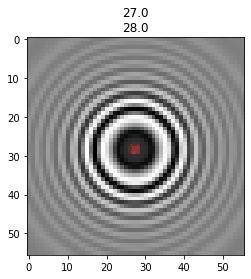

In [127]:
#Showing images of simulated particle

plt.imshow( img0_all[0], cmap='gray')
plt.title(str(labels_test[0][0]*IMAGE_SIZE)+ '\n' + str(labels_test[0][1]*IMAGE_SIZE))
plt.scatter( labels_test[0][0]*IMAGE_SIZE,  labels_test[0][1]*IMAGE_SIZE, s=70, c='r', marker='x')
plt.show()

## Training convolutional neural network

In [211]:
#load model
from keras.models import load_model
path='C:/Users/marti/Desktop/ISIBrno/model_sizingparticle.h5'
model_particle=load_model(
   path , custom_objects=None, compile=True, options=None
)

In [129]:


with generator:
    model_particle=model.fit(
        generator,
        #callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        epochs=100,
        
    )

Generating 1032 / 1024 samples before starting training
Epoch 1/100
32/32 [==============================] - 12s 153ms/step - loss: 0.1394
Epoch 2/100
32/32 [==============================] - 5s 142ms/step - loss: 0.0831
Epoch 3/100
32/32 [==============================] - 5s 144ms/step - loss: 0.0834
Epoch 4/100
32/32 [==============================] - 5s 156ms/step - loss: 0.0774
Epoch 5/100
32/32 [==============================] - 5s 168ms/step - loss: 0.0608
Epoch 6/100
32/32 [==============================] - 5s 159ms/step - loss: 0.0524
Epoch 7/100
32/32 [==============================] - 5s 161ms/step - loss: 0.0548
Epoch 8/100
32/32 [==============================] - 6s 176ms/step - loss: 0.0540
Epoch 9/100
32/32 [==============================] - 5s 163ms/step - loss: 0.0495
Epoch 10/100
32/32 [==============================] - 5s 162ms/step - loss: 0.0498
Epoch 11/100
32/32 [==============================] - 6s 189ms/step - loss: 0.0456 0s - loss: 0.04
Epoch 12/100
32/32 [===

In [130]:
# save model 
model.save('C:/Users/marti/Desktop/ISIBrno/model_sizingparticleDifPosition3.h5')


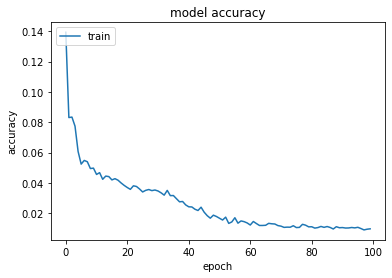

In [131]:
#ploting loss on epoch

fig = plt.gcf()
plt.plot(model_particle.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig = plt.gcf()
plt.show()


## Testing on similar data as training data

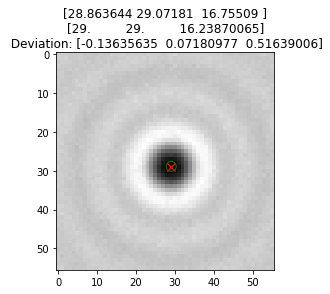

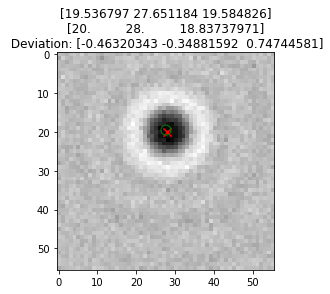

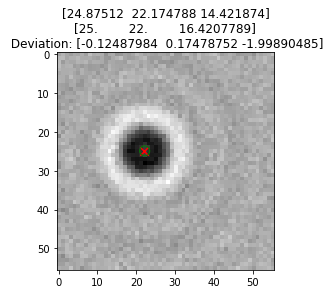

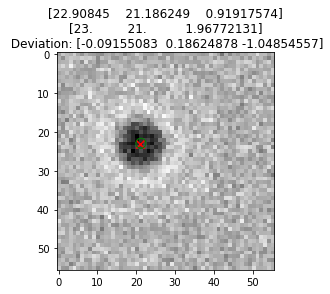

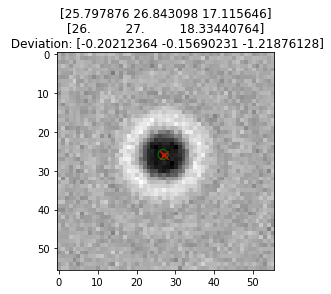

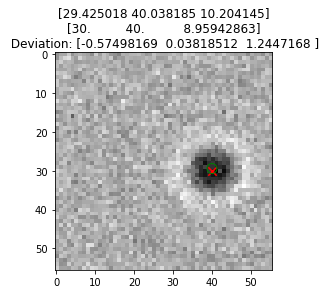

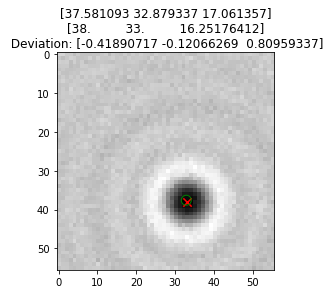

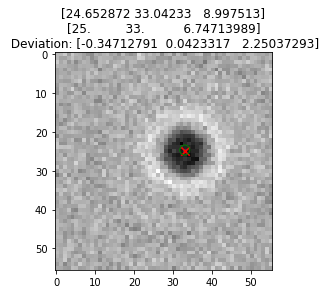

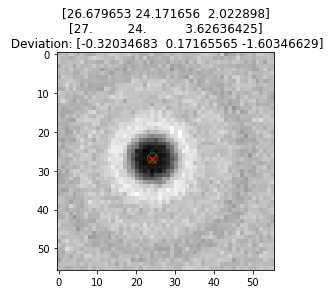

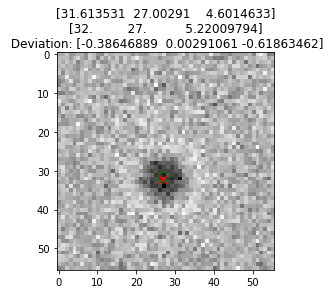

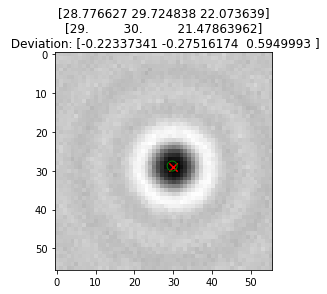

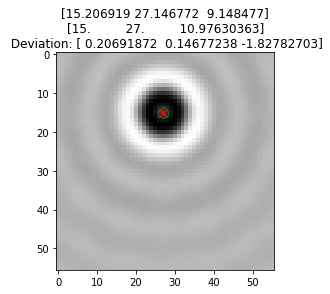

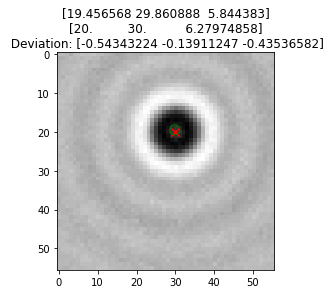

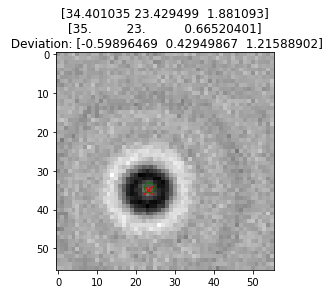

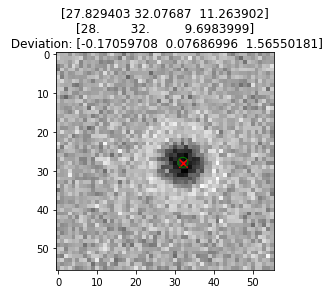

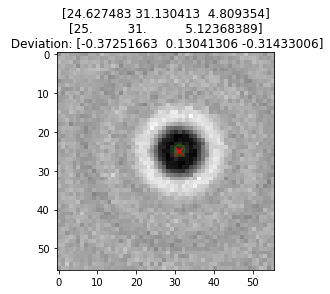

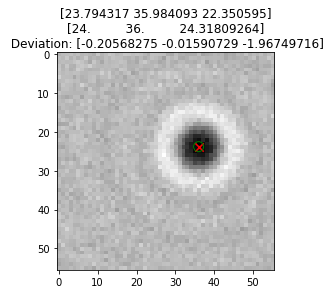

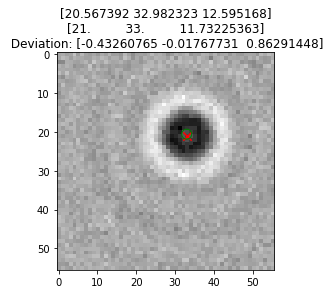

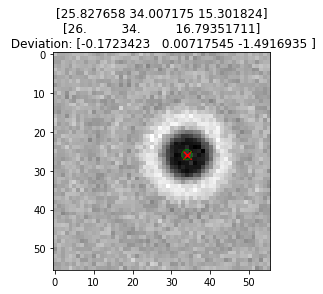

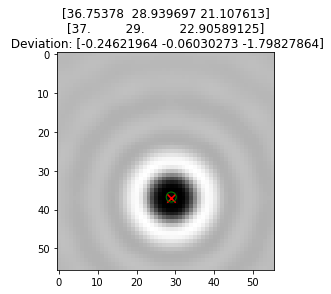

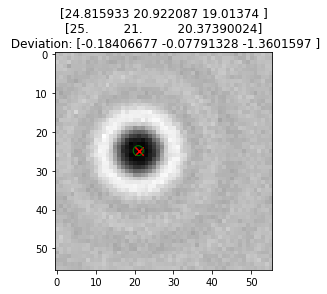

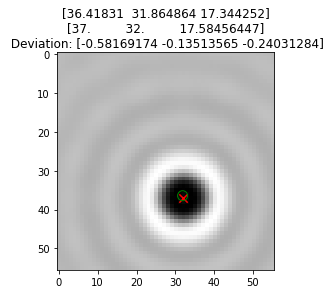

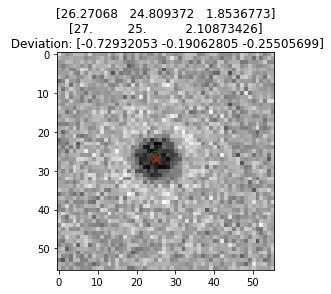

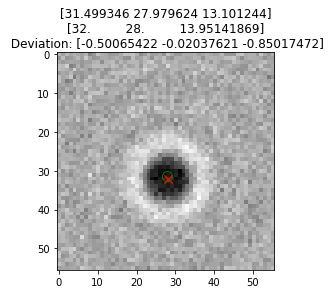

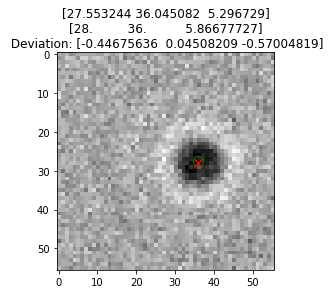

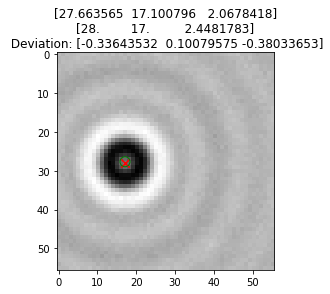

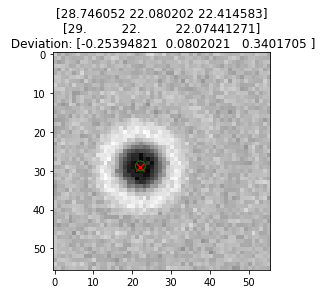

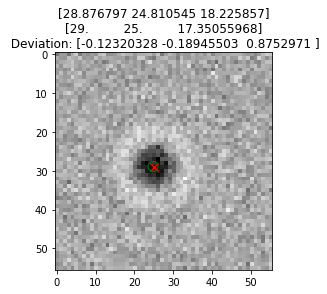

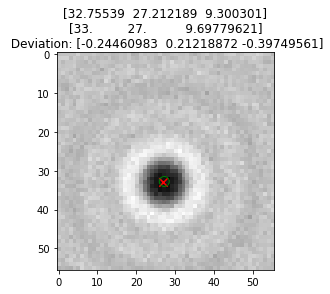

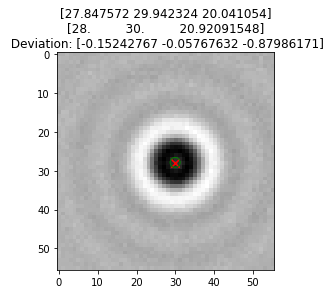

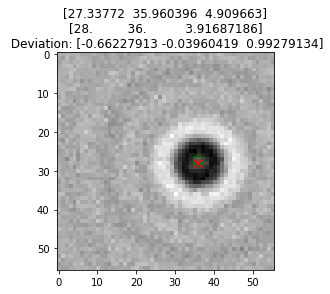

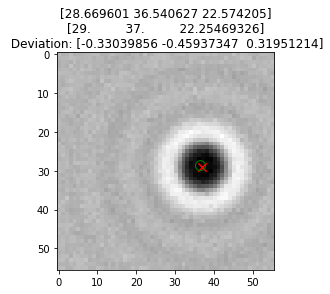

In [132]:
## this cell work only after model training ##
# testing network on new traing data from generator

images, real_positions = generator[0]

measured_positions = model.predict(images)

for i in range(images.shape[0]):
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1]* IMAGE_SIZE
    measured_position_y = measured_positions[i, 0]* IMAGE_SIZE

    real_position_x = real_positions[i, 1] * IMAGE_SIZE
    real_position_y = real_positions[i, 0] * IMAGE_SIZE
    
    
    plt.imshow(image, cmap='gray')
    plt.title(str(measured_positions[i]* IMAGE_SIZE)+ '\n' + str(real_positions[i]* IMAGE_SIZE) +'\n Deviation: ' + str((measured_positions[i]* IMAGE_SIZE) - (real_positions[i]* IMAGE_SIZE)))
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='g')
    plt.show()

## Testing on images with defined positon 

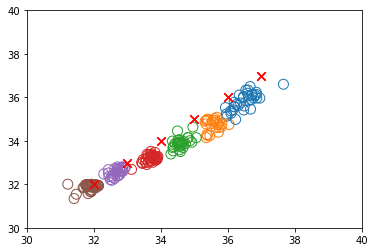

In [135]:
images_test_set_size = 200

images_test_set= [particle_test_image.update().resolve() for _ in range(images_test_set_size)]
images_test_labels= [get_position_of_particle(image) for image in images_test_set]

def_position=(IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.rot90((range(test_pos[0],test_pos[1]),range(test_pos[0],test_pos[1])))


measured_position_x =[]
measured_position_y =[]
measured_position_z =[]

for i in range(images_test_set_size):
    to_predict=images_test_set[i][:][:][:].reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)
    measured_positions = model.predict(to_predict)
    
    measured_position_x.append(measured_positions[0][0]* IMAGE_SIZE)
    measured_position_y.append(measured_positions[0][1]* IMAGE_SIZE)
    measured_position_z.append(measured_positions[0][2]* IMAGE_SIZE)
    
##uncomment for visualition, but lower number at images_test_set_size is recommended
#     plt.imshow(np.squeeze(to_predict), cmap='gray')
#     plt.scatter(images_test_labels[i][1]*IMAGE_SIZE, images_test_labels[i][0]*IMAGE_SIZE, s=70, c='r', marker='x')
#     plt.scatter(measured_position_y[i], measured_position_x[i], s=100, marker='o', facecolor='none', edgecolors='g')
#     plt.show()
    
color_bank=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def put_color(x):
    
    return{
        color_bank[np.where(def_position==int(x))[0][1]] 
    }
        
for pos in  range(np.shape(measured_position_y)[0]):
   
    plt.scatter(measured_position_y[pos], measured_position_x[pos], s=100, marker='o', facecolor='none', edgecolors=str(put_color(images_test_labels[pos][1]*IMAGE_SIZE))[2:-2])

plt.scatter(def_position, def_position, s=70, c='r', marker='x')
plt.ylim([30, 40])
plt.xlim([30, 40])
plt.show()

In [57]:
edgecolors=put_color(images_test_labels[pos][1]*IMAGE_SIZE)
edgecolors

{'#2ca02c'}

# Testing on simulated data

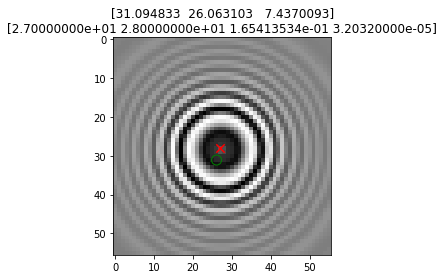

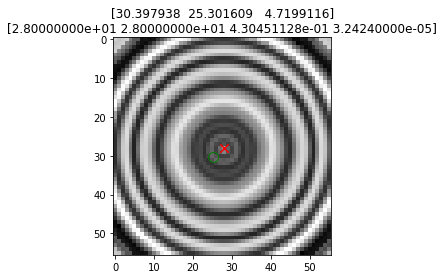

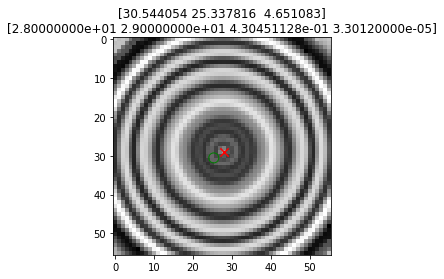

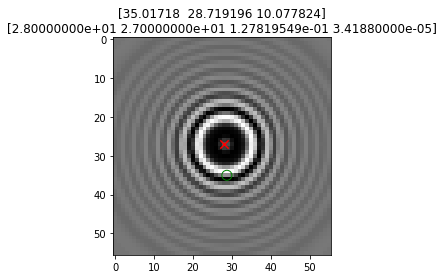

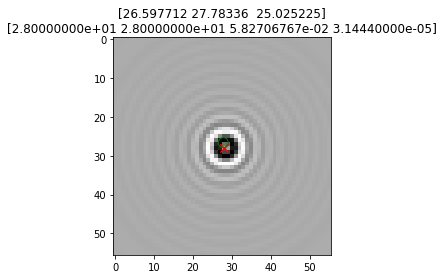

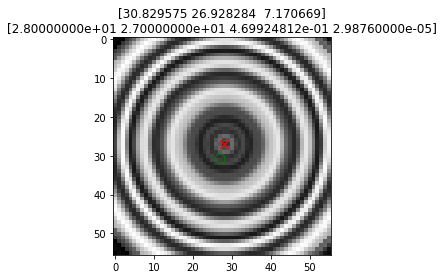

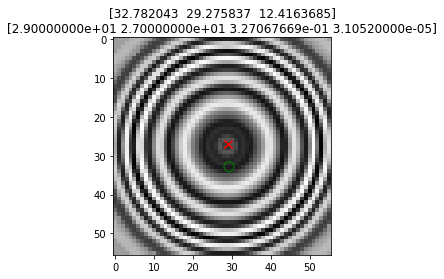

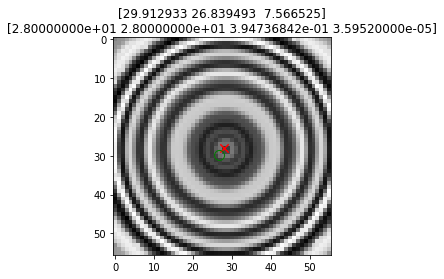

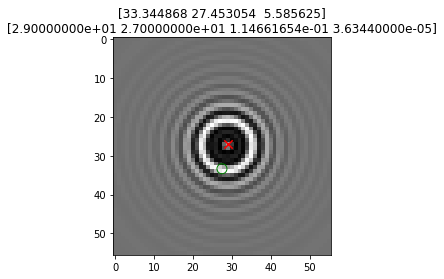

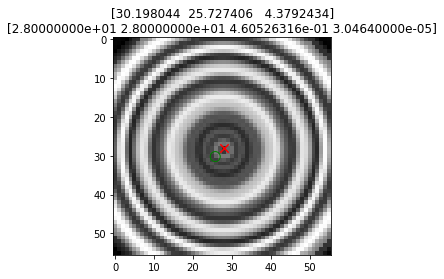

In [134]:
images= img0_all
real_positions=labels_test[:,[0,1]]
measured_positions = model.predict(images)

for i in range(images.shape[0]):
    
    
    image = np.squeeze(images[i])
    
    measured_position_x = measured_positions[i, 1]* IMAGE_SIZE
    measured_position_y = measured_positions[i, 0]* IMAGE_SIZE

    real_position_x = real_positions[i, 0] * IMAGE_SIZE
    real_position_y = real_positions[i, 1] * IMAGE_SIZE
    
    
    plt.imshow(image,cmap='gray')              
    plt.title(str(measured_positions[i]* IMAGE_SIZE)+ '\n' + str(labels_test[i]* IMAGE_SIZE))
    plt.scatter(real_position_x, real_position_y, s=70, c='r', marker='x')
    plt.scatter(measured_position_x, measured_position_y, s=100, marker='o', facecolor='none', edgecolors='g')
    plt.show()



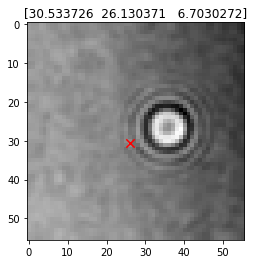

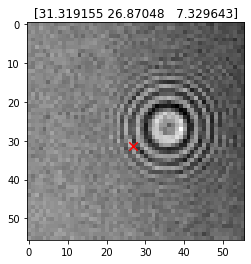

In [133]:
# testing on captured from video of particle
path='C:/Users/marti/Pictures/per.png'
path_noise='C:/Users/marti/Pictures/noise.png'

images=cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)/255
images=images[0:IMAGE_SIZE,0:IMAGE_SIZE]

images_noise=cv.cvtColor(cv.imread(path_noise), cv.COLOR_BGR2GRAY)/255
images_noise=images_noise[0:IMAGE_SIZE,0:IMAGE_SIZE]

images=images_noise-images
images_raw=images[0:IMAGE_SIZE,0:IMAGE_SIZE]


# plt.imshow(images,cmap='gray')
# plt.show()
# plt.imshow(images_noise,cmap='gray')
# plt.show()
# plt.imshow(images_noise-images,cmap='gray')
# plt.show()


# mask= np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
# images_s = cv.filter2D(images, -1, mask)

# mask_smooth = np.ones((3,3),np.float32)/6
# images_smooth = cv.filter2D(images,-1,mask_smooth)

blured_images = cv.GaussianBlur(images,(3,3),0)

# def FT_mag(image):
#     FT=np.fft.fft2(image)
#     FT_mag=20*np.log(np.abs(FT))
#     return  np.asarray(FT_mag,dtype=np.uint8)

# spect=FT_mag(images)
# spect_noise=FT_mag(images_noise)

# plt.imshow(spect_noise,cmap='gray')
# plt.show()
# plt.imshow(spect,cmap='gray')
# plt.show()
# plt.imshow(spect_noise-spect,cmap='gray')
# plt.show()


images=blured_images.reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)

measured_positions = model.predict(images)

measured_position_x = measured_positions[0, 1]*IMAGE_SIZE
measured_position_y = measured_positions[0, 0]*IMAGE_SIZE

plt.imshow(images[0], cmap='gray')
plt.title(str(measured_positions[0]*IMAGE_SIZE))
plt.scatter(measured_position_x, measured_position_y, s=70, c='r', marker='x')
plt.show()

images=images_raw.reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)
measured_positions = model.predict(images)

measured_position_x = measured_positions[0, 1]*IMAGE_SIZE
measured_position_y = measured_positions[0, 0]*IMAGE_SIZE

plt.imshow(images[0], cmap='gray')
plt.title(str(measured_positions[0]*IMAGE_SIZE))
plt.scatter(measured_position_x, measured_position_y, s=70, c='r', marker='x')
plt.show()

In [230]:
#in_progress

path_to_video=  'C:/Users/marti/Documents/Holodetect_letni_staz_2021/exp_data/SiO2_600nm_holo_noglass_Cam_19550_Cine7.avi'
part_video= cv.VideoCapture(path_to_video)

while True:
    ret,frame=part_video.read()
    cv.imshow('Frame',frame)
    
    if ret==False:
        break
part_video.release()        
        

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-u4kjpz2z\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Na mále částice z experimentálních dat je síť skoro nepoužitelná. U větších částic jako je v předešlé buňce je sice určení středu relativně blízko, bohužel z důvodů dalšího určování parametrů je tato detekce neužitečná. 
To je možná způsobeno:
    1. rozdílem v trenovacím a testovacím datasetem
    2. Přeučení sítě a tím snižení generalizace neuronové sítě
    3. Špatně nastavené tránovací data
    4. Malý dataset
    
Průběh loss funkce je od ideálu až moc strmá 